In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from joblib import parallel_backend
from sklearn.pipeline import Pipeline




In [2]:
# Define the file path and name
file_path = '/Users/shchan/Documents/Programming/Postgrad_Computer_science/Modules/CSCK503 Machine Learning in Practice June 2024/Week 8/Assignment/end of module assignment/data/'
# merge_file_name = 'MajorRoadTrafficData.csv'
file_name = 'MajorRoadTrafficData.csv'

# file_path = '../data/MajorRoadTrafficData.csv'
df = pd.read_csv(file_path+file_name)

Missing values in each column:
 Unnamed: 0              0
GridId                  0
Toid                    0
GRID_ExactCut_ID        0
Location_ExactCut       0
BoroughName_ExactCut    0
Lts                     0
Length (m)              0
Emissions               0
Year                    0
Pollutant               0
Emissions Unit          0
VehicleType             0
Emission Value          0
RowID                   0
TLRN                    0
MotorwayNumber          0
Speed (kph)             0
AADT                    0
VKM                     0
dtype: int64
Number of rows after dropping NaN in 'Emission Value': 336912
   Length (m)  Speed (kph)      AADT       VKM
0   -0.327321     1.164856  0.095732 -0.023502
1   -0.578696     0.199224 -0.353113 -0.246166
2    2.431609     0.470222  0.095732  1.043801
3   -0.583481     0.099102 -0.353113 -0.246166
4    1.360420    -0.594989  0.242550  0.915810
Predicted values: [3.83181763 0.39211565 0.07862428 1.94123654 0.15378862]
Mean Squared Err

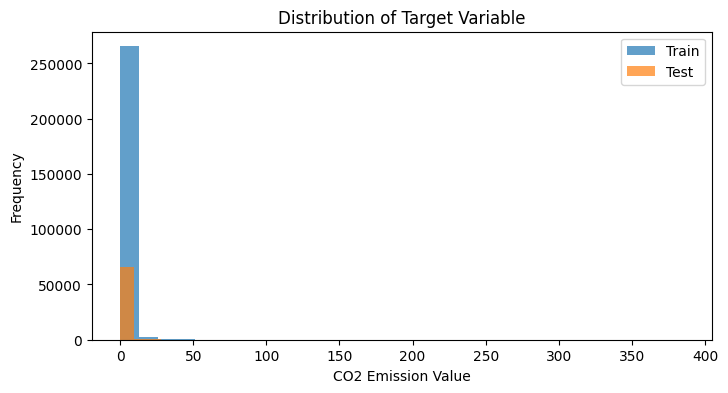

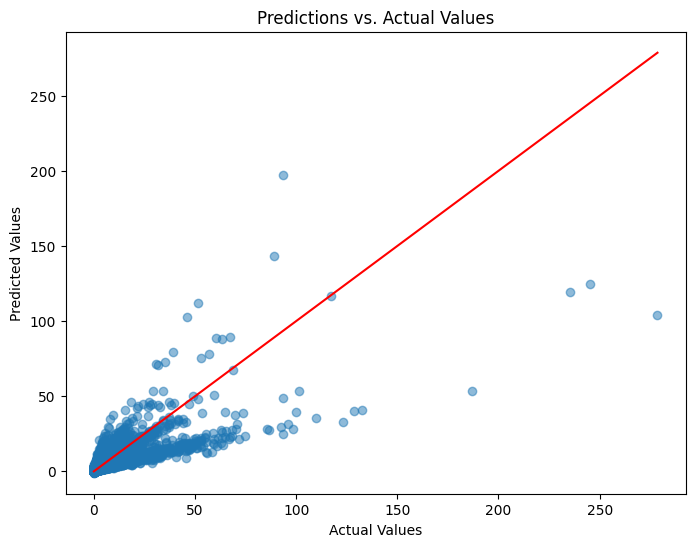

In [3]:
# Step 1: Handling Missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Step 2: Removing Duplicates
df = df.drop_duplicates()

# Encode the Pollutant column first
pollutant_encoder = LabelEncoder()
df['Pollutant'] = pollutant_encoder.fit_transform(df['Pollutant'].astype(str))

# Find the encoded value for 'CO2' in the 'Pollutant' column
co2_encoded_value = pollutant_encoder.transform(['CO2'])[0]

# Filter the DataFrame to include only rows where the Pollutant is CO2
df_co2 = df[df['Pollutant'] == co2_encoded_value]

# Drop rows with NaN in 'Emission Value'
df_co2 = df_co2.dropna(subset=['Emission Value'])

# Print the number of rows after dropping
print(f"Number of rows after dropping NaN in 'Emission Value': {df_co2.shape[0]}")

# Encode the remaining categorical variables
categorical_columns = ['Location_ExactCut', 'BoroughName_ExactCut', 'Emissions', 'Emissions Unit', 'VehicleType', 'TLRN', 'MotorwayNumber']
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col in categorical_columns:
    if col in df_co2.columns:
        df_co2[col] = label_encoders[col].fit_transform(df_co2[col].astype(str))

# Step 3: Outlier Detection and Treatment using IQR method
numeric_df = df_co2.select_dtypes(include=[np.number])

Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Aligning DataFrame and IQR series for proper comparison
df_aligned, IQR_aligned = df_co2.align(IQR, axis=1, copy=False)
Q1_aligned, _ = df_co2.align(Q1, axis=1, copy=False)
Q3_aligned, _ = df_co2.align(Q3, axis=1, copy=False)

df_co2 = df_co2[~((df_aligned < (Q1_aligned - 1.5 * IQR_aligned)) | (df_aligned > (Q3_aligned + 1.5 * IQR_aligned))).any(axis=1)]

# Select features and target
selected_features = ['Length (m)', 'Speed (kph)', 'AADT', 'VKM']  # Adjust based on your actual selected features
X = df_co2[selected_features]
y = df_co2['Emission Value']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame for the scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Print the final selected features
print(X_scaled_df.head())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Train and evaluate Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_lr = linear_reg.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

# Display results
print("Predicted values:", y_pred_lr[:5])
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plot the distribution of target values
plt.figure(figsize=(8, 4))
plt.hist(y_train, bins=30, alpha=0.7, label='Train')
plt.hist(y_test, bins=30, alpha=0.7, label='Test')
plt.title('Distribution of Target Variable')
plt.xlabel('CO2 Emission Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot predictions vs. actual values for Linear Regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.title('Predictions vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()